# Convergence of upper and lower bound over time

Note that the events in the plot are only based on the upper bound iterations.

In [38]:
import pandas as pd

data = pd.read_json("./05_clean_data.json.zip")
# data = data.drop_duplicates(subset=["instance"])
data

,instance,#Variables,#Clauses,iteration_info,baseline_alg,initial_sample_path,initial_sample_size,lower_bound,optimized_sample_size,time_used_by_yasa,timelimit_for_samplns,samplns_used
0,busybox_2020-12-16_21-53-05,1050,996,"[{'nbrhd_tuples': 222, 'nbrhd_confs': 4, 'iter...",YASA(m=1),2023-03-01_13-51-03/38_1_7_5_sample.csv,39,18,23,2.278,897.722,True
1,email,10,17,"[{'nbrhd_tuples': 70, 'nbrhd_confs': 7, 'itera...",YASA(m=1),2023-03-01_13-51-03/3_1_7_5_sample.csv,7,6,6,0.199,899.801,True
2,WaterlooGenerated,580,879,"[{'nbrhd_tuples': 248, 'nbrhd_confs': 36, 'ite...",YASA(m=1),2023-03-01_13-51-03/34_1_7_1_sample.csv,149,82,82,1.438,898.562,True
3,FeatureIDE,19,27,"[{'nbrhd_tuples': 214, 'nbrhd_confs': 8, 'iter...",YASA(m=1),2023-03-01_13-51-03/7_1_7_5_sample.csv,12,7,8,0.207,899.793,True
4,FeatureIDE,19,27,"[{'nbrhd_tuples': 215, 'nbrhd_confs': 9, 'iter...",YASA(m=1),2023-03-01_13-51-03/7_1_7_4_sample.csv,12,7,8,0.208,899.792,True
...,...,...,...,...,...,...,...,...,...,...,...,...
225,Violet,101,203,"[{'nbrhd_tuples': 178, 'nbrhd_confs': 7, 'iter...",YASA(m=1),2023-03-01_13-51-03/19_1_7_1_sample.csv,27,14,17,0.288,899.712,True
226,DMIE,366,627,"[{'nbrhd_tuples': 241, 'nbrhd_confs': 5, 'iter...",YASA(m=1),2023-03-01_13-51-03/30_1_7_5_sample.csv,27,14,17,0.597,899.403,True
227,fiasco_2020-12-01_14-09-14,258,1542,"[{'nbrhd_tuples': 236, 'nbrhd_confs': 19, 'ite...",YASA(m=1),2023-03-01_13-51-03/25_1_7_3_sample.csv,224,196,196,1.152,898.848,True
228,SortingLine,39,77,"[{'nbrhd_tuples': 206, 'nbrhd_confs': 12, 'ite...",YASA(m=1),2023-03-01_13-51-03/14_1_7_3_sample.csv,17,9,9,0.202,899.798,True


## Extend the data by some additional information on the best values

In [27]:
# Find the best values for each instance as reference.
best_solutions = (
    data[["instance", "initial_sample_size", "optimized_sample_size"]]
    .groupby("instance")
    .min()
    .reset_index()
    .rename(
        columns={
            "initial_sample_size": "best_baseline",
            "optimized_sample_size": "best_lns_ub",
        }
    )
)
best_lb = (
    data[["instance", "lower_bound"]]
    .groupby("instance")
    .max()
    .reset_index()
    .rename(columns={"lower_bound": "best_lb"})
)
best_values = best_solutions.merge(best_lb, left_on="instance", right_on="instance")
# add them to the data as reference
data = data.merge(best_values, left_on="instance", right_on="instance")
data = data[data["baseline_alg"] == "FIDE-YASA(m=1)"]

## A look onto the data never hurts

In [28]:
data

,instance,#Variables,#Clauses,iteration_info,baseline_alg,initial_sample_path,initial_sample_size,lower_bound,optimized_sample_size,time_used_by_yasa,timelimit_for_samplns,samplns_used,best_baseline,best_lns_ub,best_lb


The data field `iteration_info` contains a list of dicts for each iteration. This dict looks as follows:
```
{ 'nbrhd_tuples': 166,  # the tuples to be covered in this iteration
  'nbrhd_confs': 5,     # the number of configurations deleted from the sample
  'iteration': 0,       # the number of the iteration, in this case the first iteration
  'lb': 3.0,            # the current best lb (global)
  'ub': 23,             # the current best ub (global)
  'time': 1.0297019481658936,    # overall time at the end of this iteration
  'iteration_time': 0.48791050910949707,   # time in this iteration
  'events': [[0.0350489616394043, 'neighborhood_selected'],   # times of events in this iteration. Good for finding the culprit of long runtimes.
   [0.24133801460266113, 'local_cds_computed'],
   [0.29517436027526855, 'model_built'],
   [0.48662543296813965, 'model_optimized'],
   [0.48789548873901367, 'neighborhood_optimized'],
   [0.48791003227233887, 'global_lb_iteration_finished']]}
```

In [29]:
instance_infos = (
    data[["instance", "#Variables", "#Clauses"]]
    .drop_duplicates()
    .sort_values(by=["#Variables", "#Clauses"])
)
instance_infos

,instance,#Variables,#Clauses


## Extract the iteration data from each optimization

Bring them in a format that can easily be plotted by seaborn.

In [30]:
import pandas as pd


# Collect the data from the iteration_info events.
class EventCollector:
    def __init__(self):
        self.events = {
            "time": [],
            "val": [],
            "type": [],
            "instance": [],
            "path": [],
            "alg": [],
            "initial_sample_size": [],
            "y": [],
            "final": [],
        }

    def __call__(self, row):
        print(row)
        it_data = row["iteration_info"]

        def add(val, lbub, time, final=False):
            if time > 900:
                return
            self.events["time"].append(time / 60)
            self.events["val"].append(val)
            self.events["type"].append(lbub)
            self.events["instance"].append(row["instance"])
            self.events["alg"].append(row["baseline_alg"])
            self.events["path"].append(row["initial_sample_path"])
            self.events["initial_sample_size"].append(row["initial_sample_size"])
            self.events["y"].append(100 * (val / row["best_lb"]))
            self.events["final"].append(final)

        # add a zero entry
        add(0, "Lower", 0)
        add(row["initial_sample_size"], "Upper", 0)
        for event in it_data:
            add(
                event["lb"],
                "Lower",
                event["time"],
                final=event["lb"] == row["lower_bound"],
            )
            add(
                event["ub"],
                "Upper",
                event["time"],
                final=event["ub"] == row["optimized_sample_size"],
            )


ec = EventCollector()
data[data["baseline_alg"] == "FIDE-YASA(m=1)"].sort_values(
    by=["#Variables", "#Clauses"]
).apply(ec, axis=1)
t = pd.DataFrame(ec.events)

instance                NaN
#Variables              NaN
#Clauses                NaN
iteration_info          NaN
baseline_alg            NaN
initial_sample_path     NaN
initial_sample_size     NaN
lower_bound             NaN
optimized_sample_size   NaN
time_used_by_yasa       NaN
timelimit_for_samplns   NaN
samplns_used            NaN
best_baseline           NaN
best_lns_ub             NaN
best_lb                 NaN
dtype: float64


## Feature Models on which SampLNS did not finish a single iteration in time

These models have very large initial samples (more than a thousand configurations), for which the current implementation is not equipped.
The problem lies more in the data structures than the actual approach.
They should be feasible with some extra effort in making those data structures more efficient.

*A lower bound is still computed for these instances, but without iterations of SampLNS, only the final lower bound is saved after SampLNS aborted.*

In [31]:
t_ = t.groupby(["instance", "path"])["time"].max().reset_index()
unsolved_instances = t_[t_["time"] == 0]["instance"].unique().tolist()
unsolved_instances

[]

## Plot the convergence for all other models.

In [32]:
solved_instances = [
    x for x in instance_infos["instance"].tolist() if x not in unsolved_instances
]

In [33]:
# Prepare plotting
import seaborn as sns

sns.set_theme()
import matplotlib.pyplot as plt

In [34]:
def plot_lb_ub_progress(data, axis, xmax=16, single_instance=False):
    instance_descr = "Model"
    bound_descr = "Bound"
    t_ = data.rename(columns={"instance": instance_descr, "type": bound_descr})
    if single_instance:
        sns.lineplot(
            data=t_,
            ax=axis,
            x="time",
            y="y",
            style=bound_descr,
            hue="path",
            units="path",
            estimator=None,
            markers=False,
            palette="tab10",
            drawstyle="steps-post",
            dashes=[(1.5, 1.5), (3, 3)],
            legend=False,
        )
        sns.scatterplot(
            data=t_[t_[bound_descr] == "Upper"],
            ax=axis,
            x="time",
            y="y",
            hue="path",
            marker="X",
            palette="tab10",
            legend=False,
        )
    else:
        sns.lineplot(
            data=t_,
            ax=axis,
            x="time",
            y="y",
            style=bound_descr,
            hue=instance_descr,
            units="path",
            estimator=None,
            markers=False,
            palette="tab10",
            drawstyle="steps-post",
            dashes=[(1.5, 1.5), (3, 3)],
        )
        sns.scatterplot(
            data=t_[t_[bound_descr] == "Upper"],
            ax=axis,
            x="time",
            y="y",
            hue=instance_descr,
            marker="X",
            palette="tab10",
            legend=False,
        )
    axis.set_xlim(-0.1, xmax)
    axis.set_xlabel("Time in (min)")
    axis.set_ylabel("Relative to best lower bound (%)")
    if single_instance:
        axis.set_title(
            f"Convergence of upper and lower bound - {data['instance'].tolist()[0]}"
        )
    else:
        axis.set_title("Convergence of upper and lower bound")

### All models in one plot

This shows us that most models really make quick progress and only a few take a little longer.

/tmp/ipykernel_21343/939038844.py:32: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(
/tmp/ipykernel_21343/939038844.py:46: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


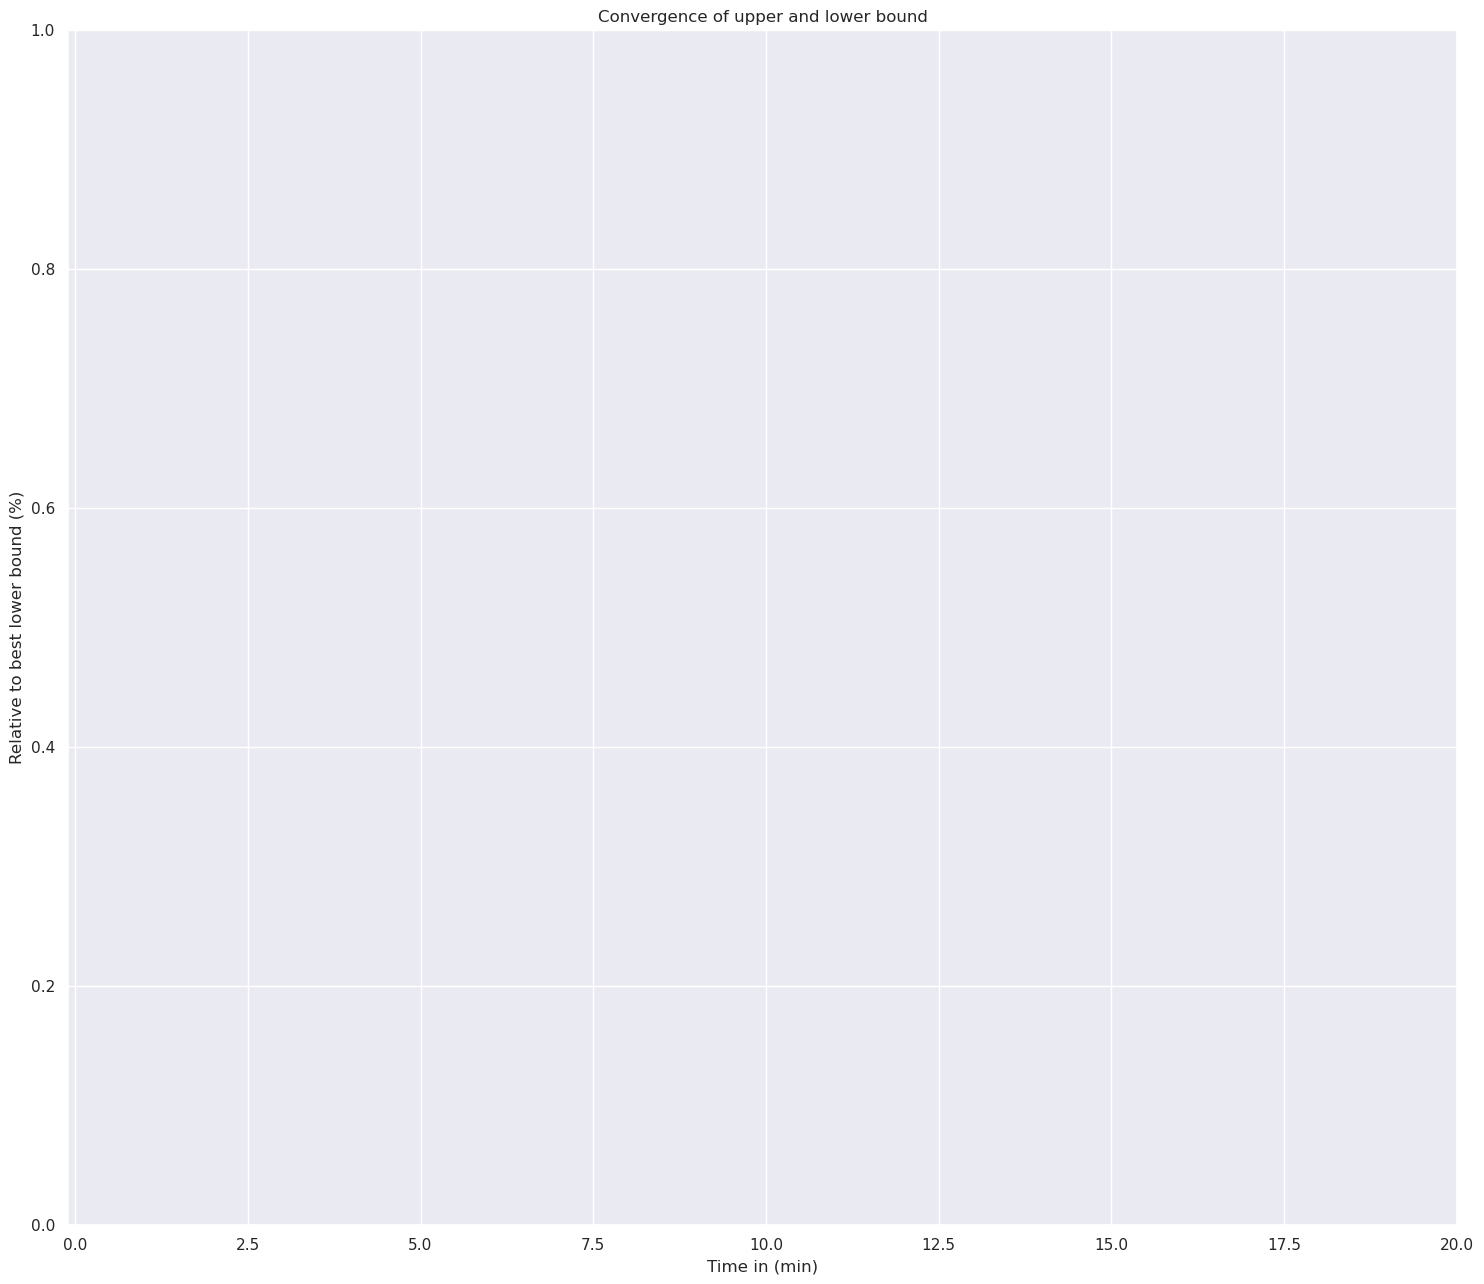

In [35]:
plt.figure(figsize=(15, 13))
plot_lb_ub_progress(t[t["instance"].isin(solved_instances)], plt.gca(), xmax=20)
plt.tight_layout()
plt.show()

### Every model with all its five runs.

In [36]:
for i in range(1, len(solved_instances), 1):
    plt.figure(figsize=(10, 5))
    plot_lb_ub_progress(
        t[t["instance"].isin(solved_instances[i : i + 1])],
        plt.gca(),
        xmax=15.1,
        single_instance=True,
    )
    plt.tight_layout()
    plt.show()

## Looking onto a selection of instances in a single plot

In [37]:
ec = EventCollector()
selection = [
    "PPU",
    # small, optimal initial sample, no improvement, reached lower bound, progress within seconds + largest system for which an existing sampling algorithm is optimal
    "axTLS",
    # small, bad initial sample, large improvement, tight lower bound, progress for 0/1 min + smallest system that we cannot optimally solve
    "berkeleyDB2",
    # small, bad initial sample, large improvement, reached lower bound, progress for 6/3 min + one of the most significant improvements (43% + optimal afterwards)
    "fs_2017-05-22",
    # medium, good initial sample, small improvement, tight lower bound, progress for 0/10 min + smallest improvement (near-optimal sample still improved)
    "busybox_2020-12-16_21-53-05",
    # medium, bad initial sample, improvement over ~6 minutes, quick progress on lb.
    "FreeBSD-8_0_0"
    # medium, bad initial sample, large improvement, far lower bound, progress for 15/15 min + system with the largest remaining gap between LB=30 and sample=59 (almost 100%)
]
data[data["instance"].isin(selection)].drop_duplicates(subset=["instance"]).sort_values(
    by=["#Variables", "#Clauses"]
).apply(ec, axis=1)
t_selected = pd.DataFrame(ec.events)
t_selected["instance"] = t_selected["instance"].apply(lambda s: s[:15])

instance                NaN
#Variables              NaN
#Clauses                NaN
iteration_info          NaN
baseline_alg            NaN
initial_sample_path     NaN
initial_sample_size     NaN
lower_bound             NaN
optimized_sample_size   NaN
time_used_by_yasa       NaN
timelimit_for_samplns   NaN
samplns_used            NaN
best_baseline           NaN
best_lns_ub             NaN
best_lb                 NaN
dtype: float64


TypeError: 'float' object is not subscriptable

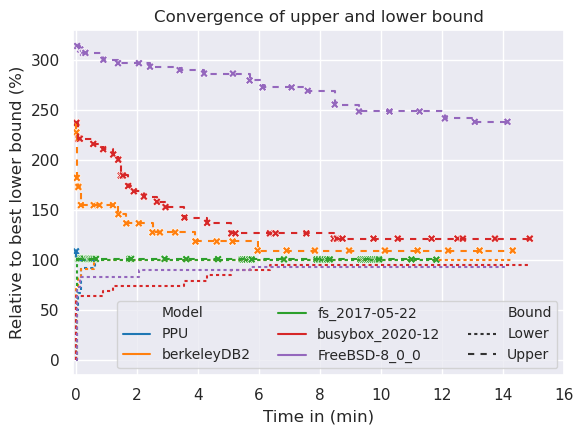

In [ ]:
plt.figure(figsize=(6, 4.5))
plot_lb_ub_progress(t_selected, plt.gca(), xmax=16)
plt.legend(ncols=3, loc="lower right", prop={"size": 10})
plt.tight_layout()
plt.savefig("./plots/01_12_convergence_of_selected_models.pdf")
plt.show()

## Time of last change

To get a better grasp of the necessary time.

In [ ]:
time_until_last_change = (
    t[t["final"] & (t["instance"].isin(solved_instances))]
    .groupby(["instance", "path", "type"])[["time"]]
    .min()
    .reset_index()
    .groupby(["instance", "type"])[["time"]]
    .mean()
)
time_until_last_change

time
instance                    type           
APL                         Lower  0.175321
                            Upper  0.036784
APL-Model                   Lower  3.245461
                            Upper  1.120704
BankingSoftware             Lower  0.580680
...                                     ...
soletta_2017-03-09_21-02-40 Upper  8.109217
toybox_2006-10-31_23-30-06  Lower  0.094598
                            Upper  0.078446
toybox_2020-12-06_00-02-46  Lower  5.568355
                            Upper  3.410337

[86 rows x 1 columns]

In [ ]:
(time_until_last_change.groupby("instance")[["time"]].max() < 3).sum()

time    16
dtype: int64

In [ ]:
time_until_last_change.reset_index().groupby("type")[["time"]].mean()

,time
type,
Lower,3.750551
Upper,5.902218
